# Reproducible Declarative DAG workflows in Jupyter Notebooks

This notebook demonstrates how one can use [yadage](https://github.com/lukasheinrich/yadage) in Jupyter notebooks to re-use previously defined (possibly by a third party) to run scientific workflows. By referencing docker images, the workflow authors uniquely specify the one (or more) sofware environment in which the individual pieces of the workflows must be executed.

The execution of the workflow can be launches and monitored from within this Jupyter notebook. The docker image running this jupyter server (lukasheinrich/yadageipython), does not need to include any of the software used in the workflows, but rather acts as an orchestrator, user interface. It also comes with standard python based analysis tools (numpy, matplotlib, scipy) in order to further analyze the data fragments produced by the workflows within the context of the notebook



## Preparation

First off we load a JavaScript extension for yadage widget, so that we can track workflow progress visually

In [1]:
%%javascript
require.config({paths: {
        vis: "http://cdnjs.cloudflare.com/ajax/libs/vis/4.17.0/vis",
        yadage: "https://rawgit.com/lukasheinrich/yadage-ipython/master/yadagealpha"
    }
});

<IPython.core.display.Javascript object>

On the python side, we start with some basic imports that allow us to load the workflow and prepare our work directory

In [2]:
import os
import shutil
from packtivity.statecontexts import poxisfs_context as statecontext
from yadage.yadagemodels import YadageWorkflow
from yadage.workflow_loader import workflow
from yadage.clihelpers import setupbackend_fromstring, prepare_workdir_from_archive
import logging
logging.basicConfig()

First, we clean up any residues of previous runs and download some required input data for the workflow (in this case a number of text files) from a public repository

In [3]:
repolocation = 'https://raw.githubusercontent.com/lukasheinrich/weinberg-exp/master/example_yadage'

workdir = 'fromipython'
try:
    shutil.rmtree(workdir)
except OSError:
    pass
finally:
    prepare_workdir_from_archive(
        workdir,
        '{}/input.zip'.format(repolocation)
    )

Second, we load a workflow definition from the repo:
    
The workflow is described using YAML/JSON files that specify the necessary software environment, commands and relationship between individual stages of the workflow:

[Click here to see e.g. the step definitions](https://github.com/lukasheinrich/weinberg-exp/blob/master/example_yadage/steps.yml)

## Simulating high-energy particle collisions using Monte Carlo generators

The workflow will generate proton proton collisions using domain-specific software from the high-energy physics community using a number or parallel threads and later convert them into a JSONLines file. There are a number of user-controllable parameters that are passed to the workflow. In this case

* the number of events to generate
* the random number seeds:
* the beam energy and polarization

In [4]:
#load the JSON wflow spec
wflowspec = workflow('rootflow.yml',repolocation) 


#define root workdirectory in which data fragements will end up 
rootcontext = statecontext.make_new_context(workdir)  

#finally create a workflow object
wflow = YadageWorkflow.createFromJSON(wflowspec,rootcontext)


#initialize workflow with parameters
wflow.view().init({
        'nevents':10000,
        'seeds':[1,2,3],
        'runcardtempl':'{}/init/run_card.templ'.format(os.path.realpath(workdir)),
        'proccardtempl':'{}/init/sm_proc_card.templ'.format(os.path.realpath(workdir)),
        'sqrtshalf':45,
        'polbeam1':0,
        'polbeam2':0
})

#set up a backend that we will use
backend = setupbackend_fromstring('multiproc:4') #options are: multiprocessing pool, ipython cluster, celery cluster

### Backend options:

Yadage curently supports a number of different backends that allow it to distribute the workflow of the workflow across multiple cores or even multiple servers/worker nodes

* **Multiprocessing** Pool (default)
* **IPython cluster** (make sure to start a cluster either via the browser or by executing the ipcluster command in a separate shell session)
* **Celery cluster** (this needs a more complicated setup including a message broker such as Redis and separate celery worker processes)

Now that we have the workflow ready, let's give ourselves a nice ui object with which we can interact. This is a IPython widget that will track the state of the workflow as it is executing/

In [5]:
import yadage_widget
ui = yadage_widget.WorkflowWidget(wflow)
ui

One option is to run the workflow in *headless mode*, without any manual intervention. This will schedule all workflow steps in the correct order. 

**Note**:

If the docker images to the necessary software needed for the workflow execution are not found locally, yadage will automatically pull the docker images before executing the steps. On the first run, this may slow down the execution of the workflow a little bit depending on the size of the necessary software and its dependencies. Any subsequent runs will be much faster. 

In [8]:
from adage import rundag
rundag(wflow,
       update_interval = 1,
       backend = backend,
       additional_trackers=[ui.adagetracker]
)

We can also reset a part of the workflow and re-run the necessary steps (by re-executing the cell above)

In [7]:
ui.reset('madevent','/subchain/0')

We can get access the results of workflows and subworkflows

In [9]:
wflow.view().getSteps('merge')[0].result

{'jsonlinesfile': '/Users/lukas/Code/demo/fromipython/merge/out.jsonl'}

Now we can use the software that is installed in the host (or docker image) running the notebook (this could e.g. be a service such as Binder or Everware) to further analyze the data. In this case we will plot a distribution of the high energy collisions generated by the workflow above.

In [10]:
import json
with open(wflow.view().getSteps('merge')[0].result['jsonlinesfile']) as f:
    parsed = map(json.loads,f.readlines())

In [11]:
costhetas = []
for e in parsed:
    els = [p for p in e['particles'] if p['id'] == 11]
    mus = [p for p in e['particles'] if p['id'] == 13]
    assert len(mus) == 1
    assert len(els) == 1
    mu = mus[0]
    el = els[0]
    el_px, el_py, el_pz = [el[x] for x in ['px','py','pz']]
    mu_px, mu_py, mu_pz = [mu[x] for x in ['px','py','pz']]
    costheta = mu_pz/el_pz
    costhetas.append(costheta)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


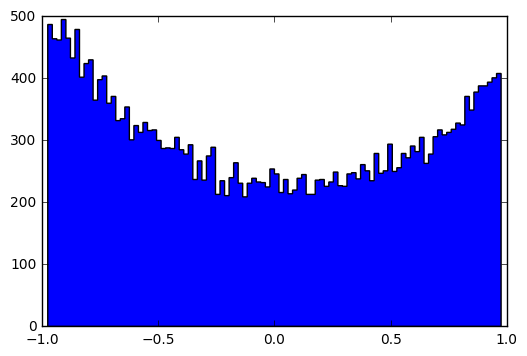

In [13]:
_,_,_ = plt.hist(costhetas, bins = 100, histtype='stepfilled')

In [14]:
print 'Voila!'

Voila!
